# Intro

**The goals here are:**

1. Evaluate assumptions of Linear Regression and adjust feature engineering to best conform to them.
2. Experiment with feature creation based on discrete ranges of continuous target, and explain how it could help meet linear assumptions.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
import cyrtranslit
from sklearn import preprocessing, model_selection, metrics, feature_selection, ensemble, linear_model, cross_decomposition, feature_extraction, decomposition
from sklearn.pipeline import Pipeline
from scipy import stats

import lightgbm as lgb
import time
color = sns.color_palette()

%matplotlib inline

In [2]:
train = pd.read_pickle('../../train.pkl',compression='zip')

test = pd.read_pickle('../../test.pkl',compression='zip')

In [3]:
ru_stop = nltk.corpus.stopwords.words('russian')

In [6]:
features = pd.read_pickle('../3.NLP StopWords NGrams/train_nlp_features7.pkl',compression='zip')

In [18]:
qt = preprocessing.QuantileTransformer(
    output_distribution='normal',
    subsample=4e5
)
pt = preprocessing.PowerTransformer(
    method='box-cox',
    standardize=False
)

# Assumptions of Linear Regression

- Linear Relationship between features and outcome.
- Error is Normally Distributed.
- Error is uniform along Range of Predicted Values
- Features aren't correlated.

In [8]:
X_train,X_val,y_train,y_val = model_selection.train_test_split(
    features,
    train.deal_probability
)

In [9]:
linear = linear_model.LinearRegression()

linear.fit(X_train,y_train)

df = pd.DataFrame({'residual':y_val - linear.predict(X_val),
                   'y': y_val,
                   'y_pred': linear.predict(X_val)})

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


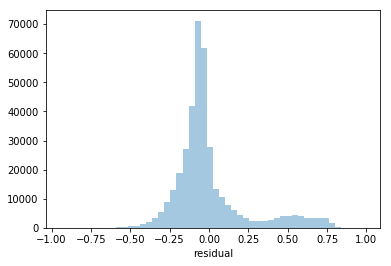

In [10]:
sns.distplot(df.residual,kde=False)
plt.show()

- Most residuals are slightly negative. That means most errors are overestimations. 
- There's a fair amount of positive error extending to 0.75, which means for plenty of points, predictions are far lower than it should.

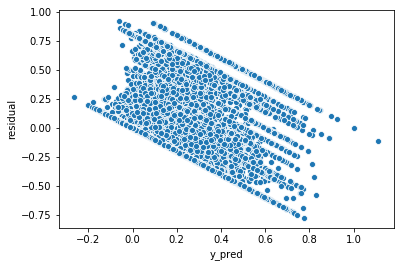

In [16]:
index = np.random.choice(len(df),int(1e5))
sns.scatterplot(df.iloc[index].y_pred, df.iloc[index].residual)
plt.show()

- These residuals are positives for predictions closer to zero and negative for predictions closer to 1.
- That means when I predict lower values my predictions should be higher, and when I predict higher values my predictions should be lower.

# Correcting Assumptions

- y in its natural state

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


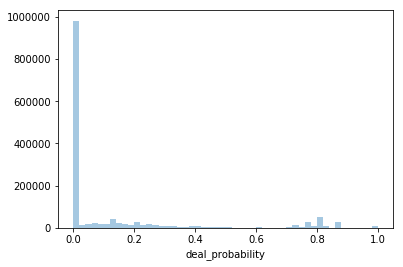

In [25]:
sns.distplot(train.deal_probability,kde=False)
plt.show()

- y with no zeros.

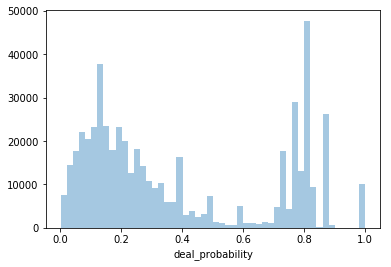

In [27]:
sns.distplot(train[train.deal_probability>0].deal_probability,kde=False)
plt.show()

- Sorted values of y

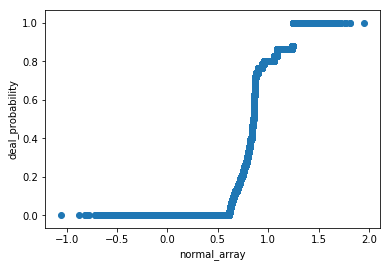

In [30]:
plt.scatter(sorted(np.random.normal(0.5,0.3,int(3e5))),sorted(train.sample(int(3e5)).deal_probability))
plt.ylabel('deal_probability')
plt.xlabel('normal_array')
plt.show()

## Zero Range

In [4]:
zeroes = train[train.deal_probability == 0]

## Lower Range

In [10]:
lower = train[(train.deal_probability>0)&(train.deal_probability<0.65)]

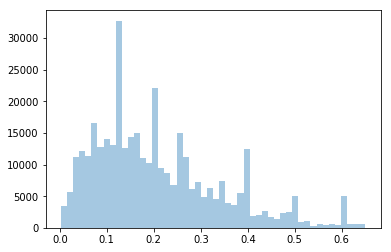

In [126]:
sns.distplot([lower.deal_probability.values],kde=False)
plt.show()

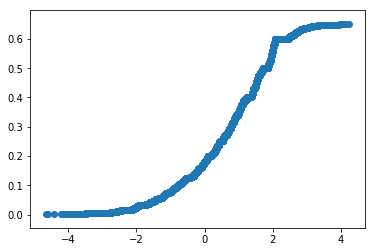

In [127]:
plt.scatter(sorted(np.random.normal(0,1,len(lower))),sorted(lower.deal_probability))
plt.show()

**Transforming Distribution of Lower Target Range**
- PowerTransformer isn't robust enough compared with QuantileTransformer.

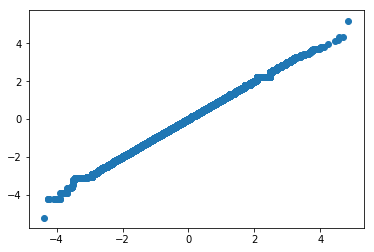

In [129]:
# Quantile Transformer
plt.scatter(sorted(np.random.normal(0,1,len(lower))),sorted(qt.fit_transform(lower.deal_probability.values.reshape(-1,1))))
plt.show()

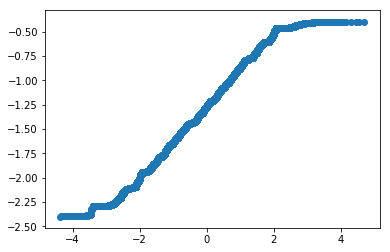

In [130]:
# Power Transformer
plt.scatter(sorted(np.random.normal(0,1,len(lower))),sorted(pt.fit_transform(lower.deal_probability.values.reshape(-1,1))))
plt.show()

## Upper Range

In [20]:
upper = train[(train.deal_probability >= 0.65)]

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


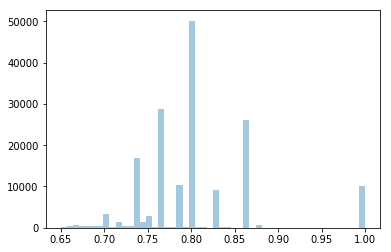

In [92]:
sns.distplot([upper.deal_probability.values],kde=False)
plt.show()

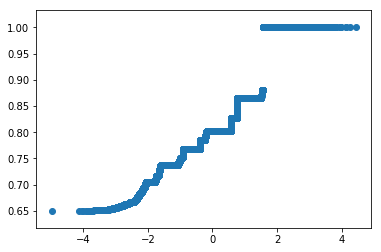

In [93]:
plt.scatter(sorted(np.random.normal(0,1,len(upper))),sorted(upper.deal_probability))
plt.show()

**Transforming Distribution of Upper Range**

- Quantile Transformer has issues dealing with the empty area at the top of the range.

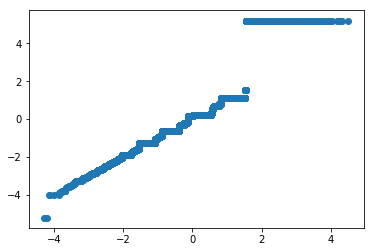

In [21]:
plt.scatter(sorted(np.random.normal(0,1,len(upper))),sorted(qt.fit_transform(upper.deal_probability.values.reshape(-1,1))))
plt.show()

- PowerTransformer is slightly better in this case.

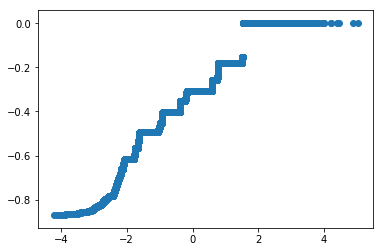

In [22]:
plt.scatter(sorted(np.random.normal(0,1,len(upper))),sorted(pt.fit_transform(upper.deal_probability.values.reshape(-1,1))))
plt.show()

# Vocabulary per Discrete Target Range

In [38]:
upper_str = ' '.join(upper.title.astype(str).values)
lower_str = ' '.join(lower.title.astype(str).values)
zeroes_str = ' '.join(zeroes.title.astype(str).values)

In [39]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(1,2),
    #min_df=0.0005,
    #max_df=0.0005
)
vec.fit([upper_str,lower_str,zeroes_str])
print(len(vec.get_feature_names()))

254857


In [40]:
# Get counts for all titles. They're split into three documents
counts = vec.transform([upper_str,lower_str,zeroes_str])
del upper_str,lower_str,zeroes_str

# Convert CSR into DataFrame and Transpose. Now terms are on the index
counts = pd.DataFrame(counts.toarray()).T

# Extract terms from vocabulary, sort by index and add to df index
vocab = vec.vocabulary_
terms = [f for f in vocab]
terms = pd.DataFrame(terms)
terms['index'] = [vocab[k] for k in vocab] ; del vocab
terms.sort_values(by='index',inplace=True)
terms = terms[0].values.tolist()
counts.index = terms ; del terms

In [45]:
# Make an indicator of where the highest frequency is for each term
group = []
for i in np.arange(len(counts)):
    group.append(np.argmax(counts.iloc[i].values))      
counts['group'] = group ; del group

In [50]:
counts.tail()

,0,1,2,group
ёрочка,0.000000,0.000000,0.000015,2
ёршик,0.000000,0.000000,0.000046,2
ёта,0.000000,0.000024,0.000012,1
ёх,0.000040,0.000009,0.000018,0
ёхкомфорчатая,0.000067,0.000000,0.000000,0


In [57]:
zero_vocab = counts[counts.group == 2].sort_values(by=2,ascending=False).index.tolist()
lower_vocab = counts[counts.group == 1].sort_values(by=1,ascending=False).index.tolist()
upper_vocab = counts[counts.group == 0].sort_values(by=0,ascending=False).index.tolist()

vocabs = [upper_vocab,lower_vocab,zero_vocab]
vocabs = pd.DataFrame(vocabs)
vocabs = vocabs.T
vocabs.columns=['up_voc','low_voc','zero_voc']

In [136]:
vocabs.head()

,up_voc,low_voc,zero_voc
0,ВАЗ,м²,Продам
1,iPhone,эт,Платье
2,Коляска,квартира,Куртка
3,LADA,сот,платье
4,Samsung,участке,Туфли


vocabs.to_pickle('vocabs.pkl')

---

# Components for Range Zero

In [26]:
vocabs = pd.read_pickle('vocabs.pkl')

In [27]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(1,2),
    #min_df=0.0005,
    #max_df=0.0005,
    vocabulary=vocabs.zero_voc.dropna()
)
vec.fit(train['title'].astype(str).tolist()+test['title'].astype(str).tolist())
print(len(vec.get_feature_names()))

166964


In [28]:
# Word counts for train. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['title'].astype(str).tolist())

In [29]:
counts.shape

(1503424, 166964)

- 160k is too many columns. Since we know they're sorted by popularity, triming to the first 30k means we're keeping the most recurring terms in this target range.

In [30]:
counts = counts[:,:30000]

In [24]:
trange = train[train.deal_probability==0].index.tolist()

In [19]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),2000):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        print('CSR Columns:',low_col,up_col)
        index = np.random.choice(len(train),size=int(4e5),replace=False)
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSRegression(n_components=5)
        reduce.fit(sample,train.iloc[index].deal_probability)
        print('Score for feature range:',
              reduce.score(sample,train.iloc[index].deal_probability))
        # Get scores for values of this target range
        tindex = np.random.choice(trange,size=int(4e5),replace=False)
        tsample = counts[tindex,low_col:up_col].toarray()
        print('Score for sampled target range values of feature range:',
              reduce.score(tsample,train.iloc[tindex].deal_probability))

        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                #print('Indexes:',low_idx,up_idx,'Columns:',low_col,up_col)
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                #print('Sample shape:',sample.shape)
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}_{}'.format(low_col,up_col,i) for i in range(0,5)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        # Get scores for values of this target range
        print('Aggregate score for target range:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange],y=train.iloc[trange].deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

CSR Columns: 0 2000
Score for feature range: 0.08070848997673365
Score for sampled target range values of feature range: 0.0
Aggregate score: [0.0775847  0.07445585 0.07697172 0.07616326]
Aggregate score for target range: [1. 1. 1. 1.]
Aggregate shape: (1503424, 5) 

CSR Columns: 2000 4000
Score for feature range: 0.010187257669342697
Score for sampled target range values of feature range: 0.0
Aggregate score: [0.0838812  0.08055795 0.08323575 0.08227703]
Aggregate score for target range: [1. 1. 1. 1.]
Aggregate shape: (1503424, 10) 

CSR Columns: 4000 6000
Score for feature range: 0.006958576442683495
Score for sampled target range values of feature range: 0.0
Aggregate score: [0.08727762 0.08396811 0.08663618 0.08592479]
Aggregate score for target range: [1. 1. 1. 1.]
Aggregate shape: (1503424, 15) 

CSR Columns: 6000 8000
Score for feature range: 0.005967439507144734
Score for sampled target range values of feature range: 0.0
Aggregate score: [0.08971382 0.08652734 0.08910561 0.0883

- The first few column batches produced the most increase in scores. These are terms whose majority is found on titles with zero del_probability. They're ordered by popularity, so once you have the first few thousand of them, the rest are meaningless for everything else.
- At the same time, these terms are the majority of all the terms in the dataset. So having gotten rid of so many of them with this procedure is also a good thing. The other two sets of terms aren't nearly as large as this one.

In [20]:
reduced.shape

(1503424, 75)

reduced.to_pickle('zero_nlp.pkl',compression='zip')

In [23]:
reduced = pd.read_pickle('zero_titles.pkl',compression='zip')

- So just by knowing the top terms in ads with zero probability, we can explain 10% of variance.

In [22]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))

Aggregate score: [0.10084564 0.09741477 0.09991847 0.09950985]


In [22]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange],y=train.iloc[trange].deal_probability))

Aggregate score: [1. 1. 1. 1.]


- Noticed we kept getting zero-R^2-scores for every sampled target range? Well, let's explore that below.

In [31]:
index = np.random.choice(len(train),size=int(4e5),replace=False)
sample = counts[index,:2000].toarray()
reduce = cross_decomposition.PLSRegression(n_components=5)
reduce.fit(sample,train.iloc[index].deal_probability)
print('Score for feature range:',
      reduce.score(sample,train.iloc[index].deal_probability))

Score for feature range: 0.08219023713922469


In [32]:
tindex = np.random.choice(trange,size=int(4e5),replace=False)
tsample = counts[tindex,:2000].toarray()
print('Score for sampled target range values of feature range:',
      reduce.score(tsample,train.iloc[tindex].deal_probability))

Score for sampled target range values of feature range: 0.0


- Since all target values in this target category were the same (zero), the score is zero. But this doesn't mean we're getting things wrong.
- RMSE might be better for this case, because it's a measure of error.

In [37]:
pred = reduce.predict(tsample)

In [38]:
metrics.mean_squared_error(train.iloc[tindex].deal_probability,pred)

0.020371394170309965

In [39]:
metrics.r2_score(train.iloc[tindex].deal_probability,pred)

0.0

- This is really good. 2% error for ads that are actually zero.
- Now let's compare with the error for any ads.

In [40]:
pred = reduce.predict(sample)

In [36]:
metrics.mean_squared_error(train.iloc[index].deal_probability,pred)

0.06209914107914853

In [41]:
metrics.r2_score(train.iloc[index].deal_probability,pred)

0.08219023713922469

- Understandably the error is higher for ads of all kinds. At least we know we succedded in increasing the sensitivity of this target range.

## Second Round of Decomposition

In [42]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(reduced,train.deal_probability)
print(reduce.score(reduced,train.deal_probability))

0.09950263582213069


In [43]:
reduced2 = reduce.transform(reduced)

In [44]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2,y=train.deal_probability))

Aggregate score: [0.10089915 0.09748388 0.09999809 0.09957845]


In [47]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=10,estimator=linear_model.LinearRegression(),
            X=reduced2[trange],y=train.iloc[trange].deal_probability))

Aggregate score: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


- Zero del_probability ads are 64% of all ads in train data.

In [49]:
len(trange)/len(train)

0.6482655591503129

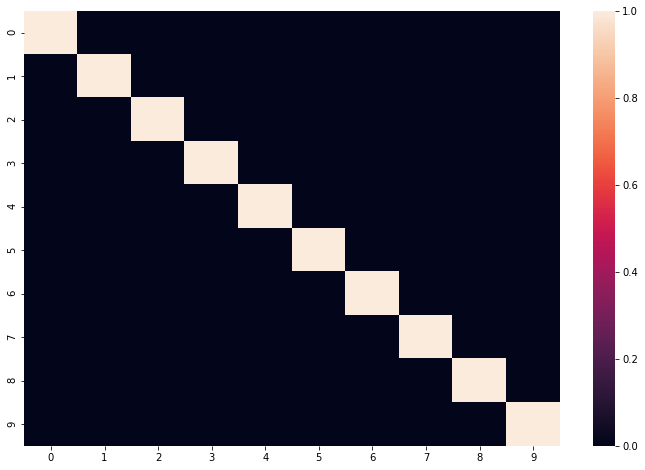

In [19]:
plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(reduced2).corr())
plt.show()

In [32]:
reduced2 = pd.DataFrame(reduced2,columns=['zero_titles{}'.format(i) for i in range(0,10)])

reduced2.to_pickle('zero_titles.pkl',compression='zip')

# Components for Lower Range

In [4]:
vocabs = pd.read_pickle('vocabs.pkl')

In [5]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(1,2),
    #min_df=0.0005,
    #max_df=0.0005,
    vocabulary=vocabs.low_voc.dropna()
)
vec.fit(train['title'].astype(str).tolist()+test['title'].astype(str).tolist())
print(len(vec.get_feature_names()))

41434


- 41k, way less than the 160k for zeros.

In [6]:
# Word counts for train. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['title'].astype(str).tolist())

In [7]:
counts.shape

(1503424, 41434)

In [8]:
counts = counts[:,:30000]

In [9]:
trange = train[(train.deal_probability>0)&(train.deal_probability<0.65)].index.tolist()

In [11]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),2000):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        print('CSR Columns:',low_col,up_col)
        index = np.random.choice(len(train),size=int(4e5),replace=False)
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSRegression(n_components=5)
        reduce.fit(sample,train.iloc[index].deal_probability)
        print('Score for feature range:',
              reduce.score(sample,train.iloc[index].deal_probability))
        # Get scores for values of this target range
        tindex = np.random.choice(trange,size=int(3e5),replace=False)
        tsample = counts[tindex,low_col:up_col].toarray()
        print('Score for sampled target range values of feature range:',
              reduce.score(tsample,train.iloc[tindex].deal_probability))

        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                #print('Indexes:',low_idx,up_idx,'Columns:',low_col,up_col)
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                #print('Sample shape:',sample.shape)
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}_{}'.format(low_col,up_col,i) for i in range(0,5)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        # Get scores for values of this target range
        print('Aggregate score for target range:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange],y=train.iloc[trange].deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

CSR Columns: 0 2000
Score for feature range: 0.004658609306173567
Score for sampled target range values of feature range: -0.2634133639618681
Aggregate score: [0.00231518 0.0023522  0.00219587 0.00219523]
Aggregate score for target range: [0.03563026 0.03392334 0.03723699 0.03388463]
Aggregate shape: (1503424, 5) 

CSR Columns: 2000 4000
Score for feature range: 0.0006816920822866335
Score for sampled target range values of feature range: -0.2567446674908771
Aggregate score: [0.00240332 0.00242315 0.00226541 0.00228546]
Aggregate score for target range: [0.03647111 0.03441902 0.03788847 0.03456289]
Aggregate shape: (1503424, 10) 

CSR Columns: 4000 6000
Score for feature range: 0.0007301687404087653
Score for sampled target range values of feature range: -0.25764670013956037


KeyboardInterrupt: 

In [12]:
reduced.shape

(1503424, 10)

reduced.to_pickle('lower_titles.pkl',compression='zip')

reduced = pd.read_pickle('lower_titles.pkl',compression='zip')

In [13]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[:,:27],y=train.deal_probability))

Aggregate score: [0.00240332 0.00242315 0.00226541 0.00228546]


In [14]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange,:27],y=train.iloc[trange].deal_probability))

Aggregate score: [0.03647111 0.03441902 0.03788847 0.03456289]


In [15]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange,:27],y=train.iloc[trange].deal_probability,
            scoring=metrics.make_scorer(metrics.mean_squared_error)
))

Aggregate score: [0.0174146  0.01755734 0.01750691 0.01748022]


- These components are too weak to be used.

# Components for Upper Range

In [4]:
vocabs = pd.read_pickle('vocabs.pkl')

In [5]:
vec = feature_extraction.text.TfidfVectorizer(
    stop_words=ru_stop,
    lowercase=False,
    #max_features=8600,
    #ngram_range=(1,2),
    #min_df=0.0005,
    #max_df=0.0005,
    vocabulary=vocabs.up_voc.dropna()
)
vec.fit(train['title'].astype(str).tolist()+test['title'].astype(str).tolist())
print(len(vec.get_feature_names()))

46459


In [6]:
# Word counts for train. CSR Matrix, tokens ordered alphabetically
counts = vec.transform(train['title'].astype(str).tolist())

In [7]:
counts.shape

(1503424, 46459)

In [8]:
counts = counts[:,:16000]

In [9]:
trange = train[(train.deal_probability >= 0.65)].index.tolist()

In [12]:
# Reduce all CSR values in batches
t = time.time()
reduced = pd.DataFrame(index=train.index)
low_col = 0
# Start iteration with columns
for col in np.arange(0,int(counts.shape[1]*1.05),2000):
    # Limiting the edge case of the last values
    if col > counts.shape[1]:
        col = counts.shape[1]
    up_col = col
    
    if up_col > low_col:
        # Train PLSR on a large sample of those columns from CSR
        print('CSR Columns:',low_col,up_col)
        index = np.random.choice(len(train),size=int(4e5),replace=False)
        sample = counts[index,low_col:up_col].toarray()
        reduce = cross_decomposition.PLSRegression(n_components=5)
        reduce.fit(sample,train.iloc[index].deal_probability)
        print('Score for feature range:',
              reduce.score(sample,train.iloc[index].deal_probability))
        # Get scores for values of this target range
        tindex = np.random.choice(trange,size=int(1e5),replace=False)
        tsample = counts[tindex,low_col:up_col].toarray()
        print('Score for sampled target range values of feature range:',
              reduce.score(tsample,train.iloc[tindex].deal_probability))

        # Nested indexes iteration
        components = pd.DataFrame()
        low_idx = 0
        for idx in np.arange(0,int(len(train)*1.1),int(3.1e5)):
            # Limiting the edge case of the last values
            if idx > len(train):
                idx = len(train)
            up_idx = idx

            if up_idx > low_idx:
                #print('Indexes:',low_idx,up_idx,'Columns:',low_col,up_col)
                sample = counts[low_idx:up_idx,low_col:up_col].toarray()
                #print('Sample shape:',sample.shape)
                sample = reduce.transform(sample)
                components = components.append(pd.DataFrame(sample))
                low_idx = idx
        components.reset_index(drop=True,inplace=True)
        components.columns = ['col_{}-{}_{}'.format(low_col,up_col,i) for i in range(0,5)]
        reduced = reduced.join(components)
        print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))
        # Get scores for values of this target range
        print('Aggregate score for target range:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced.iloc[trange],y=train.iloc[trange].deal_probability))
        print('Aggregate shape:',reduced.shape,'\n')
        low_col = col
print('Minutes:',(time.time()-t)/60)

CSR Columns: 0 2000
Score for feature range: 0.1294380863618192
Score for sampled target range values of feature range: -85.11803250427431
Aggregate score: [0.12157716 0.11609632 0.12031961 0.12113182]
Aggregate score for target range: [0.19711237 0.18565089 0.19374681 0.19438232]
Aggregate shape: (1503424, 5) 

CSR Columns: 2000 4000
Score for feature range: 0.0258347212903397
Score for sampled target range values of feature range: -99.49473886005555
Aggregate score: [0.13272583 0.12686576 0.1310508  0.13233091]
Aggregate score for target range: [0.21664801 0.21166146 0.21584868 0.21603498]
Aggregate shape: (1503424, 10) 

CSR Columns: 4000 6000
Score for feature range: 0.017871187563704316
Score for sampled target range values of feature range: -100.4402314340023
Aggregate score: [0.13695893 0.13154726 0.13596516 0.1365263 ]
Aggregate score for target range: [0.22213869 0.21873496 0.22166577 0.21979604]
Aggregate shape: (1503424, 15) 

CSR Columns: 6000 8000
Score for feature range: 

In [14]:
reduced.shape

(1503424, 40)

reduced.to_pickle('upper_titles_idf.pkl',compression='zip')

reduced = pd.read_pickle('lower_titles_idf.pkl',compression='zip')

In [13]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced,y=train.deal_probability))

Aggregate score: [0.14419607 0.13952506 0.14390911 0.14422175]


## Second Round of Decomposition

In [23]:
reduce = cross_decomposition.PLSRegression(n_components=10)
reduce.fit(reduced,train.deal_probability)
print(reduce.score(reduced,train.deal_probability))

0.14306275328847595


In [24]:
reduced2 = reduce.transform(reduced)

In [25]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2,y=train.deal_probability))

Aggregate score: [0.14425867 0.13959646 0.1439656  0.14429044]


In [26]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=reduced2[trange],y=train.iloc[trange].deal_probability))

Aggregate score: [0.16048541 0.16255903 0.16228089 0.15836029]


In [27]:
reduced2 = pd.DataFrame(reduced2,columns=['upper_titles{}'.format(i) for i in range(0,10)])

reduced2.to_pickle('upper_titles_idf.pkl',compression='zip')

reduced2 = pd.read_pickle('upper_titles_idf.pkl',compression='zip')

## Aggregate with Components of Other Ranges

In [30]:
rzero = pd.read_pickle('zero_titles_counts.pkl',compression='zip')

In [31]:
rlower = pd.read_pickle('lower_titles_count.pkl',compression='zip')

In [32]:
categorical = pd.read_pickle('categorical.pkl',compression='zip')

In [33]:
features = pd.read_pickle('../3.NLP StopWords NGrams/train_nlp_features7.pkl',compression='zip')

In [34]:
features = features.join(categorical).join(rzero).join(rlower)

In [35]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=features,y=train.deal_probability))

Aggregate score: [0.22725435 0.22227478 0.22561828 0.22613892]


In [36]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=features,y=train.deal_probability,
            scoring=metrics.make_scorer(metrics.mean_squared_error)
))

Aggregate score: [0.05221368 0.05246749 0.05234117 0.05257644]


In [37]:
features = features.join(reduced2)

In [38]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=features,y=train.deal_probability))

Aggregate score: [0.22964374 0.22470478 0.22794231 0.22865803]


In [39]:
print('Aggregate score:',model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=features,y=train.deal_probability,
            scoring=metrics.make_scorer(metrics.mean_squared_error)
))

Aggregate score: [0.05205223 0.05230356 0.05218408 0.05240529]


In [40]:
cv = model_selection.cross_val_score(
            cv=4,estimator=linear_model.LinearRegression(),
            X=features,y=train.deal_probability,
            scoring=metrics.make_scorer(metrics.mean_squared_error))

In [41]:
np.mean(cv)**.5

0.2285526008627334

---

# Analyzing  Error

In [78]:
linear = linear_model.LinearRegression()

In [79]:
X_train,X_val,y_train,y_val = model_selection.train_test_split(
    reduced2,
    train.deal_probability
)

In [80]:
linear = linear_model.LinearRegression()

linear.fit(X_train,y_train)

df = pd.DataFrame({'residual':y_val - linear.predict(X_val),
                   'y': y_val,
                   'y_pred': linear.predict(X_val)})

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


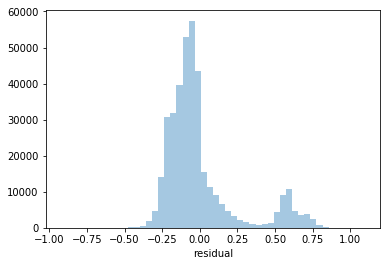

In [81]:
sns.distplot(df.residual,kde=False)
plt.show()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


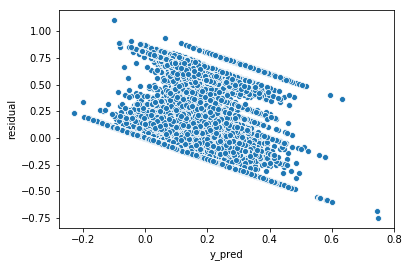

In [82]:
index = np.random.choice(len(train),int(3e5))
sns.scatterplot(df.y_pred[index],df.residual[index])
plt.show()

In [83]:
print(metrics.mean_squared_error(df.y,df.y_pred))
df[df.y_pred<0] = 0 ; df[df.y_pred>1] = 1
print(metrics.mean_squared_error(df.y,df.y_pred))

0.05942205224022927
0.05886368546616122


## Error per Target Range

In [84]:
i_0 = train[train.deal_probability==0].index.tolist()
i_low = train[(train.deal_probability>0)&(train.deal_probability<0.65)].index.tolist()
i_up = train[train.deal_probability>=0.65].index.tolist()

### Error in Range Zero

In [85]:
i_train, i_val = model_selection.train_test_split(i_0)

In [87]:
X_train = reduced2.iloc[i_train]
X_val = reduced2.iloc[i_val]
y_train = train.iloc[i_train].deal_probability
y_val = train.iloc[i_val].deal_probability

In [88]:
linear = linear_model.LinearRegression()

linear.fit(X_train,y_train)

df = pd.DataFrame({'residual':y_val - linear.predict(X_val),
                   'y': y_val,
                   'y_pred': linear.predict(X_val)})

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


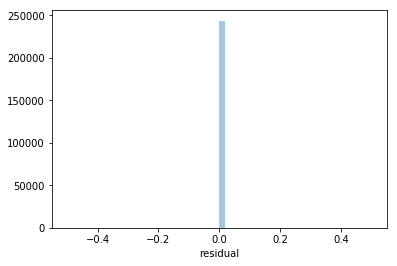

In [89]:
sns.distplot(df.residual,kde=False)
plt.show()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


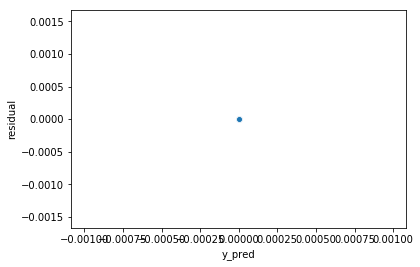

In [90]:
index = np.random.choice(len(train),int(3e5))
sns.scatterplot(df.y_pred[index],df.residual[index])
plt.show()

### Error in Lower Range

In [91]:
i_train, i_val = model_selection.train_test_split(i_low)

In [92]:
X_train = reduced2.iloc[i_train]
X_val = reduced2.iloc[i_val]
y_train = train.iloc[i_train].deal_probability
y_val = train.iloc[i_val].deal_probability

In [93]:
linear = linear_model.LinearRegression()

linear.fit(X_train,y_train)

df = pd.DataFrame({'residual':y_val - linear.predict(X_val),
                   'y': y_val,
                   'y_pred': linear.predict(X_val)})

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


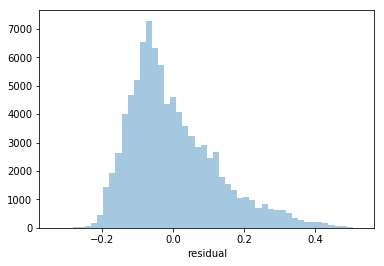

In [94]:
sns.distplot(df.residual,kde=False)
plt.show()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


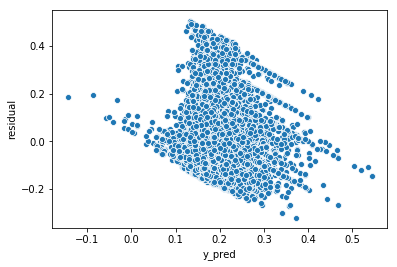

In [95]:
index = np.random.choice(len(train),int(3e5))
sns.scatterplot(df.y_pred[index],df.residual[index])
plt.show()

### Error in Upper Range

In [96]:
i_train, i_val = model_selection.train_test_split(i_up)

In [97]:
X_train = reduced2.iloc[i_train]
X_val = reduced2.iloc[i_val]
y_train = train.iloc[i_train].deal_probability
y_val = train.iloc[i_val].deal_probability

In [98]:
linear = linear_model.LinearRegression()

linear.fit(X_train,y_train)

df = pd.DataFrame({'residual':y_val - linear.predict(X_val),
                   'y': y_val,
                   'y_pred': linear.predict(X_val)})

/home/user/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


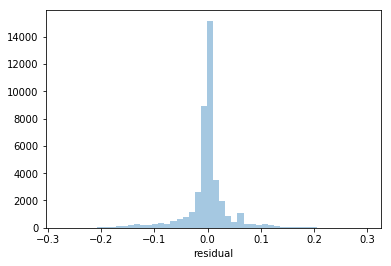

In [99]:
sns.distplot(df.residual,kde=False)
plt.show()

/home/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


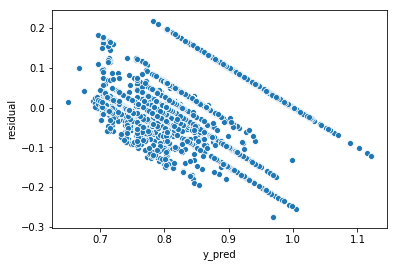

In [100]:
index = np.random.choice(len(train),int(3e5))
sns.scatterplot(df.y_pred[index],df.residual[index])
plt.show()